# ODE  model of NeuroImaging with Bayesian Inference unsing blackjax's No-U-Turn-Sampler and numpyro description of the model.

Multiple chains implementation

:::

:post: May 2, 2024
:tags: ODE model with PyMC
:category: Advanced, Demo
:author: Nina BALDY and Meysam Hashemi, INS, AMU, Marseille.
:::

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
import jax 
import jax.numpy as jnp
import multiprocessing

In [3]:
import numpyro as npr
from numpyro.infer.util import initialize_model, Predictive, init_to_value
from numpyro import plate
import numpyro.distributions as dist

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
npr.set_platform("cpu")

In [5]:
import blackjax

In [6]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"BlackJax version: {blackjax.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.26.0
JAX version: 0.4.26
Numpyro version: 0.14.0
BlackJax version: 1.1.1
Arviz version: 0.18.0


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"]

In [9]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [10]:
from Helper.ERPhelper import *

In [11]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler

In [12]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )


def multi_chain(rng_key, initial_position, target_acceptance=0.8, max_num_doublings=10) :
    
    """ Run warmup (adaptation) and sampling for multiple chains"""
    
    adapt = blackjax.window_adaptation(blackjax.nuts, 
                                   logdensity_fn, 
                                   target_acceptance_rate=target_acceptance,
                                   max_num_doublings=max_num_doublings)
    
    rng_key, warmup_key = jax.random.split(rng_key)
    (last_state, parameters), _ = adapt.run(warmup_key, initial_position, num_warmup)
    kernel = blackjax.nuts(logdensity_fn, **parameters).step
    
    rng_key, sample_key = jax.random.split(rng_key)
    chain = inference_loop(
        rng_key,
        kernel,
        last_state,
        num_sample
    )
    
    return chain

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simulations in the repo. The neural mass model used in this example has often been used in dynamical causal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

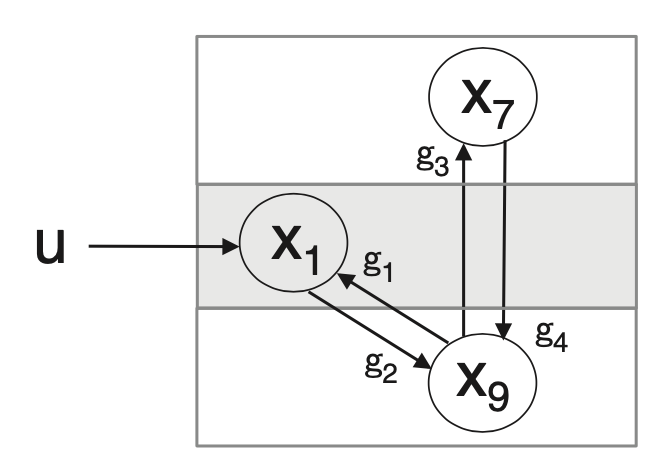

In [14]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of neural populations. Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.

$x(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The unknown model parameters represent the following:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ represents the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials.
* $\tau_{e, i}$ are the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  represents the input to each neural population

## Simulator

In [15]:
rng_key = jax.random.PRNGKey(10)

In [16]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [17]:
ns = 9
x_init=np.zeros((ns))

In [18]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [19]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [20]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 93.8 ms, sys: 4.83 ms, total: 98.6 ms
Wall time: 97 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [21]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [22]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.07790231704711914


In [23]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.0008616447448730469


## Synthetic Observation

We assume that we only have access to the activity of pyramidal neurons, and for the sake of speeding the computational time, we downsample the simuations.

In [24]:
#observation noise
sigma_true = 0.1 

In [25]:
xpy_jax = ERP_JAXOdeintSimuator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [26]:
#downsampling
ds=10

In [27]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [28]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [29]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

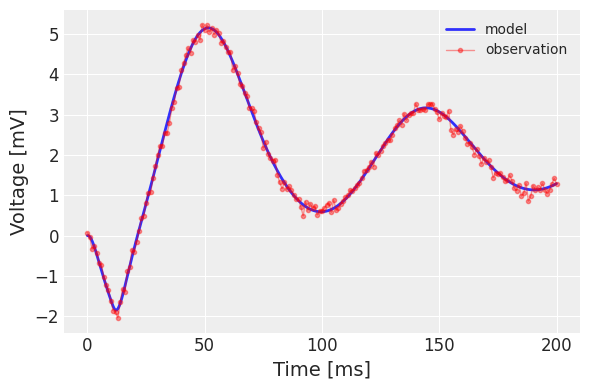

In [30]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [31]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [32]:
prior_specs = dict(shape=shape, rate=rate)

## Model

In [33]:
def model(data, prior_specs):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    xpy_obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimuator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, sigma_true), obs=xpy_obs)

### Prior predictive check

In [34]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

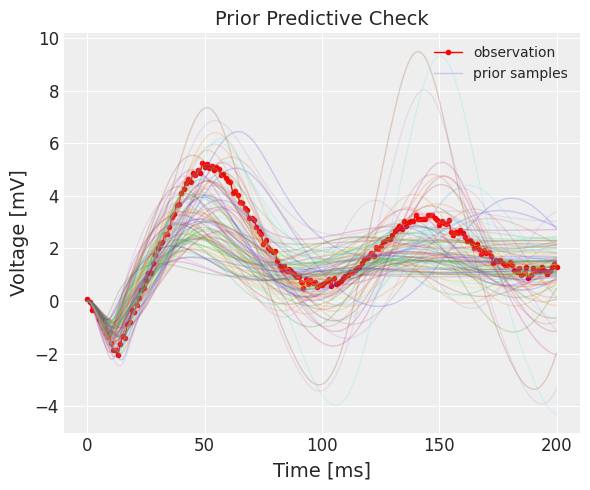

In [35]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

## Inference with NUTS in BlackJax

In [36]:
#num_chains = multiprocessing.cpu_count()
num_chains = 4

We need to translate the model into a log-probability function that will be used by Blackjax to perform inference. For that we use the initialize_model function in Numpyro’s internals. We will also use the initial position it returns to initialize the inference.

here we initialize in the 5% percentile of the prior

In [37]:
tails_5th_percentile=tails_percentile(my_var_names, prior_predictions, 0.05)    
init_to_low_prob_strategy = init_to_value(values=tails_5th_percentile)

In [38]:
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn_gen, postprocess_fn, *_ = initialize_model(
    init_key,
    model,
    model_args=(data, prior_specs),
    dynamic_args=True,
    init_strategy=init_to_low_prob_strategy
)
#postprocess_fn is the function to transform the unconstrained variables used by numpyro back to their constrained space

In [39]:
initial_position = {}
for key in my_var_names :
    initial_position[key] = np.array([init_params.z[key]] * num_chains)

Numpyro return a potential function, which is easily transformed back into a logdensity function that is required by Blackjax:

In [40]:
logdensity_fn = lambda position: -potential_fn_gen(data, prior_specs)(position)

We run 200 warmup and 200 sampling with multiple chains

In [41]:
num_warmup = 200

In [42]:
num_sample = 200

In [43]:
rng_keys = jax.random.PRNGKey(0)
keys = jax.random.split(rng_keys, num_chains)

start_time = time.time()

#run nuts inference with the multi_chain function we defined
res = jax.vmap(multi_chain)(keys, initial_position)

run_time = time.time() - start_time
print("---NUTS with BlackJax " + str(num_chains) + " chains took: %s seconds ---" % run_time)

---NUTS with BlackJax 4 chains took: 253.9731252193451 seconds ---


In [44]:
states, infos = res

In [45]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.93
There were 0.00% divergent transitions


For now, samples are in the unconstrained space used by numpyro: the values don't match the ground truth

In [46]:
idata = az.from_dict(posterior={k: v for k, v in states.position.items()})

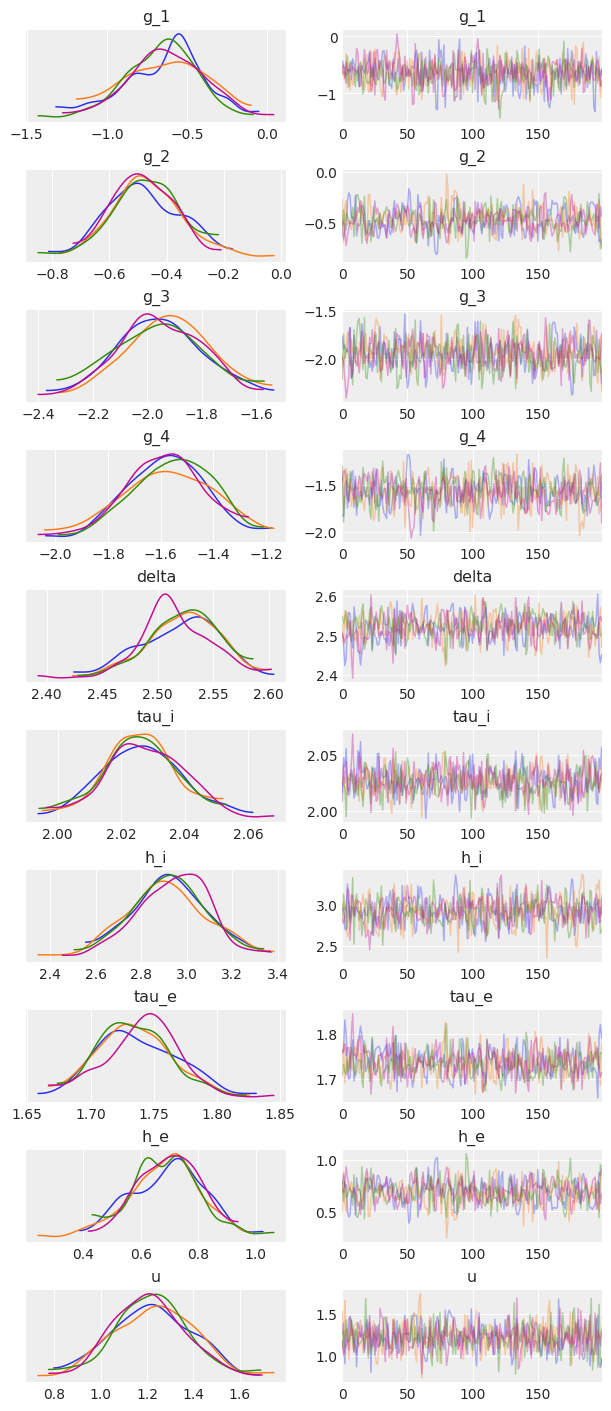

In [47]:
axes = az.plot_trace(
    idata,
    var_names=my_var_names,
    compact=False,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)


we use the post processing function we catched in the initialization phase to unmap the variables

In [48]:
#messy but works
posterior_samples_unmapped_list = []
for ichain in range(num_chains) :
    post_one_chain = {}
    for key in my_var_names :
        post_one_chain[key] = states.position[key][ichain, :]
    posterior_samples_unmapped_list.append(jax.vmap(postprocess_fn(data, prior_specs))(post_one_chain))

In [49]:
posterior_samples_unmapped = {k: [] for k in my_var_names + ['xpy_model']}
for post in posterior_samples_unmapped_list :
    for key in posterior_samples_unmapped.keys() :
        posterior_samples_unmapped[key].append(np.array(post[key]))

In [50]:
idata_unmapped = az.from_dict(posterior_samples_unmapped)

and we obtain the samples in the correct posterior space

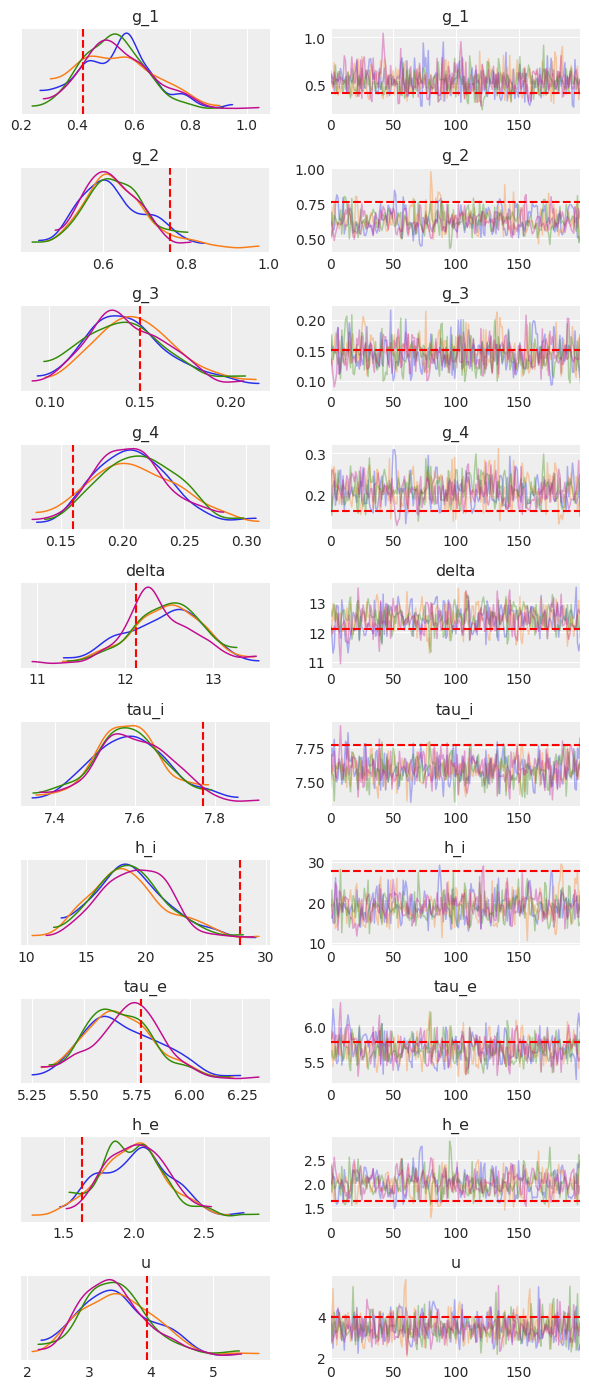

In [51]:
axes = az.plot_trace(
    idata_unmapped,
    var_names=my_var_names,
    compact=False,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
plt.tight_layout();

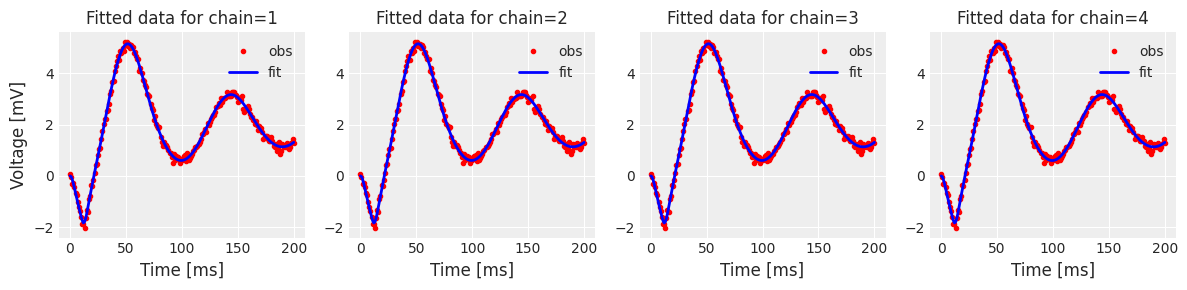

In [52]:
plot_fitted(data, idata_unmapped.posterior) ;

In [53]:
#! pip install watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 02 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.24.0

blackjax  : 1.1.1
numpy     : 1.26.0
matplotlib: 3.8.4
arviz     : 0.18.0
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpyro   : 0.14.0
seaborn   : 0.13.2
jax       : 0.4.26

Watermark: 2.4.3

